Seamless cloning method

In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [11]:
target = cv.cvtColor(cv.imread('/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/target_1.jpeg'), cv.COLOR_BGR2RGB)
source = cv.cvtColor(cv.imread('/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/source_1.jpeg'), cv.COLOR_BGR2RGB)
source = cv.resize(source, (int(source.shape[1]*2/3), int(source.shape[0]*2/3)))

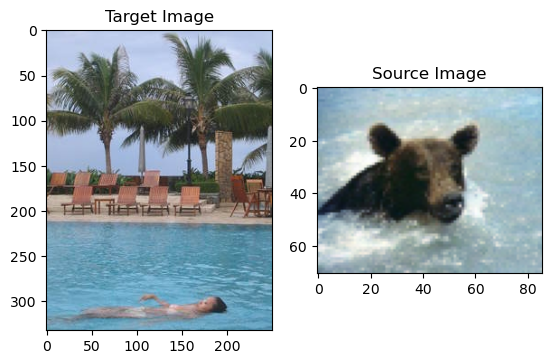

In [12]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(target)
plt.title('Target Image')
f.add_subplot(1,2,2)
plt.imshow(source)
plt.title('Source Image')
plt.show()


In [13]:
# Define position in the background image
position = (100, 250)  # Adjust the position as needed

# Create a mask based on sourceect dimensions
mask = np.zeros(source.shape[:2], dtype=source.dtype)
mask[:,:] = 255

seamless_cloning = cv.seamlessClone(source, target, mask, position, cv.NORMAL_CLONE)

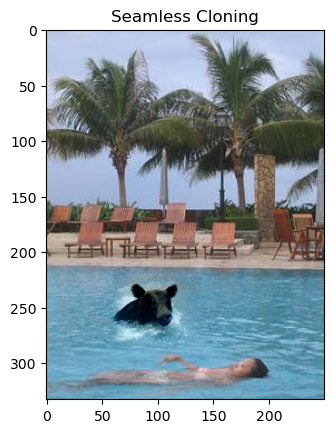

In [14]:
f = plt.figure()
plt.imshow(seamless_cloning)
plt.title('Seamless Cloning')
plt.show()

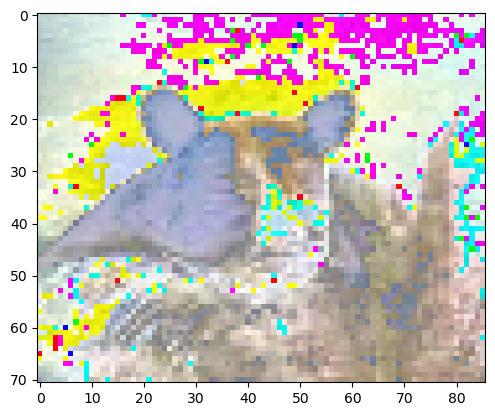

In [16]:

# Ensure both images have the same dimensions
# Ensure both images have the same dimensions
if source.shape != target.shape:
    # Resize the source image to match the dimensions of the target image
    source_image = cv.resize(source, (target.shape[1], target.shape[0]))


# Create an empty image for the result
result_image = np.zeros(source.shape, dtype=np.uint8)

# Iterate over each pixel and calculate the mixed gradient
for i in range(source.shape[0]):
    for j in range(source.shape[1]):
        source_pixel = source[i, j]
        target_pixel = target[i, j]

        # Calculate the absolute differences
        diff_source = np.abs(source_pixel - target_pixel)
        diff_target = np.abs(target_pixel - source_pixel)

        # Determine which difference is greater and set d_ij accordingly
        if np.sum(diff_source) > np.sum(diff_target):
            d_ij = source_pixel - target_pixel
        else:
            d_ij = target_pixel - source_pixel

        # Set the corresponding pixel in the result image
        result_image[i, j] = d_ij


plt.figure()
plt.imshow(result_image)
plt.show()


In [1]:
from dataclasses import dataclass
import numpy as np
import cv2

@dataclass
class Parameters:
    iterMax: int
    tol: float

def poisson_blend(background, foreground, mask, params):
    # Ensure the images have the same dimensions
    assert background.shape == foreground.shape == mask.shape

    # Create Laplacian masks for the background and foreground
    laplacian_bg = cv2.Laplacian(background, cv2.CV_64F)
    laplacian_fg = cv2.Laplacian(foreground, cv2.CV_64F)

    # Initialize the result image
    result = np.copy(background)

    for _ in range(params.iterMax):
        prev_result = result.copy()

        for channel in range(background.shape[2]):
            result[:, :, channel] = cv2.inpaint(
                result[:, :, channel],
                mask.astype(np.uint8),
                3,
                cv2.INPAINT_TELEA,
            )

        # Calculate Laplacian of the result
        laplacian_result = cv2.Laplacian(result, cv2.CV_64F)

        # Update the result using the Laplacian of the background, foreground, and result
        for channel in range(background.shape[2]):
            result[:, :, channel] = (
                    result[:, :, channel]
                    + laplacian_fg[:, :, channel]
                    - laplacian_bg[:, :, channel]
                    - laplacian_result[:, :, channel]
            )

        # Check for convergence
        diff = np.abs(result - prev_result)
        if np.max(diff) < params.tol:
            break

    return result



In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a data class for parameters
from dataclasses import dataclass

@dataclass
class Parameters:
    iterMax: int
    tol: float

# Function for Poisson blending
def poisson_blend(background, source, mask, params):
    # Ensure the images have the same dimensions
    assert background.shape == source.shape == mask.shape
    
    # Create Laplacian masks for the background and source
    laplacian_bg = cv2.Laplacian(background, cv2.CV_64F)
    laplacian_source = cv2.Laplacian(source, cv2.CV_64F)
    
    # Initialize the result image
    result = np.copy(background)
    
    for _ in range(params.iterMax):
        prev_result = result.copy()
        
        for channel in range(background.shape[2]):
            result[:, :, channel] = cv2.inpaint(
                result[:, :, channel],
                mask.astype(np.uint8),
                3,
                cv2.INPAINT_TELEA,
            )
        
        # Calculate Laplacian of the result
        laplacian_result = cv2.Laplacian(result, cv2.CV_64F)
        
        # Update the result using the Laplacian of the background, source, and result
        for channel in range(background.shape[2]):
            result[:, :, channel] = (
                result[:, :, channel]
                + laplacian_source[:, :, channel]
                - laplacian_bg[:, :, channel]
                - laplacian_result[:, :, channel]
            )
        
        # Check for convergence
        diff = np.abs(result - prev_result)
        if np.max(diff) < params.tol:
            break
    
    return result


# Load your source image
source_image_path = "/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/source_1.jpeg"  # Update with the source image path
source_image = cv2.imread(source_image_path)

# Load your target image (background)
target_image_path = "/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/target_1.jpeg"  # Update with the target image path
target_image = cv2.imread(target_image_path)

# Load your mask image
mask_path = "/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/mask_1.jpeg"  # Update with the mask image path
mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Convert the mask to grayscale

print("target shape:", target_image.shape)
print("Source shape:", source_image.shape)
print("Mask shape:", mask_image.shape)

# Define parameters for blending
parameters = Parameters(iterMax=1000, tol=1e-6)

# Perform Poisson blending
blended_image = poisson_blend(target_image, source_image, mask_image, parameters)

# Display the blended image
plt.figure()
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



target shape: (333, 250, 3)
Source shape: (107, 130, 3)
Mask shape: (107, 130)


AssertionError: 